# Tema 3: Problemas de Satisfacción de Restricciones

En búsqueda vimos que podemos resolver problemas si los planteamos como una búsqueda en un espacio de **estados**. A pesar de que estos estados pueden ser evaluados por heurísticas de dominio específico y conocer si son estados meta, para el algoritmo de búsqueda cada uno de los estados es atómico; una especie de caja negra sin estructura interna.

En este tema se discutirá una forma de resolver una gran variedad de problemas de forma más eficiente. Para esto utilizamos una representación por factores para cada estado: un conjunto de variables, cada una con un valor. Un problema es resuelto cuando cada variable tiene un valor que satisface todas las restricciones impuestas en la variable por el problema. Un problema descrito de esta manera lleva el nombre de **problema de satisfacción de restricciones** o CSP por sus siglas en Inglés.

Los algoritmos de búsqueda utilizados en la resolución de CSPs aprovechan la estructura de los estados y utilizan heurísticas de propósito general; no son específicas del problema como las que hemos discutido hasta ahora; para habilitar la solución de problemas complejos. La idea principal es eliminar grandes porciones del espacio de búsqueda simultáneamente identificando la combinación de variable-valor que viola las restricciones.

## Definiendo los problemas de satisfacción de restricciones

Para formular los CSPs vamos a utilizar una estructura muy especial para describir el problema el cual nos permite ser generales a la hora de formularlos. Decimos que un problema de satisfacción de restricciones consiste de tres componentes:

* $X$: El conjunto de variables, $\{X_1, ..., X_n\}$.


* $D$: El conjunto de dominios para cada variable, $\{D_1, D_2, ..., D_n\}$.


* $C$: El conjunto de restricciones que especifíca las reglas de asignación de las variables.

Formalmente, cada dominio $D_i$ consiste de un conjunto de valores permitidos, $\{v_1, ..., v_k\}$ para la variable $X_i$. Cada restricción consiste de una pareja $\langle alcance, relación \rangle$, donde el $alcance$ es una tupla de variables que participan en la restricción y $relación$ se refiere a la relación que define los valores que esas variables pueden tomar. Las restricciones pueden ser expresadas de forma explícita o implícita. Una relación puede ser representada explicitamente con una lista de todas las tuplas de valores que satisfacen a la restricción, o como una relación abstracta, implícita, que permite dos operaciónes: probar si una tupla es miembro de la relación y enumerar los miembros de la relación.

Por ejemplo, si $X_1$ y $X_2$ ambas tienen el dominio $\{A, B\}$, entonces la restricción *"Dos variables deben tener distintos valores"* puede ser escrita como:

* **Implícitamente:** $\langle(X_1, X_2), X_1 \neq X_2\rangle$

* **Explícitamente:** $\langle(X_1, X_2), [(A,B), (B,A)]\rangle$

Para solucionar un CSP, es necesario definir el espacio de estados y la noción de una solución. Cada estado en un CSP está definido por una **asignación** de los valores a algunas o todas las variables, $\{X_i = v_i, X_j = v_j, ...\}$. Una asignación que no viola ninguna restricción es llamada **consistente** o asignación legal. Una **asignación completa** es aquella en la que cada variable está asignada, y una **solución** a un CSP es una asignación completa consistente. Una **asignación parcial** es aquella que asigna valores solamente a algunas de las variables.



### Modelando un CSP con código: una manera

Esta es una manera de modelar un CSP; pueden haber otras. Se recomienda que usted intente otra forma de modelar un CSP para maximizar el aprendizaje del tema.

In [4]:
import copy

In [5]:
class csp_variable:
    """
    dom debe ser un set, para que ninguna tupla que representa el dominio de la variable se repita.
    var_id es el identificador de la variable. Por defecto es None.
    """
    def __init__(self, var_id = None, dom = set()):
        self.id = var_id
        self.dom = set(dom)
        self.variable = (var_id, dom)
    
    def __repr__(self):
        return "{id}".format(id=self.id)
    
    '''
        Returns a copy of the domain.
    '''
    def Domain(self):
        return copy.deepcopy(self.dom)
    
    def getID(self):
        return self.id
    
    def modifyDomain(self, newDomain):
        self.dom = newDomain

In [6]:
class csp:
    def __init__(self):
        self.X = {} # k,v pairs where k is the variable identifier and v is the domain of k.
        self.D = self.getDomains() #k,v pair where k is X[i] and v is a set representing X[i]'s domain.
        self.C = [] #list of k,v tuples where k is the set of variables involved in the constraint, and v is the constraint.
                    # Every item in C is unique.
    
    def getArcs(self):
        self.updateDomains()
        return [Ci for Ci in self.C]
    
    def getAssignments(self):
        assigned = {Xi: Xi.Domain() for Xi in self.X if len(Xi.Domain()) == 1}
        return assigned
    
    def AssignValueTo(self, var, val):
        for Xi in self.X:
            if Xi == var:
                Xi.modifyDomain({val}) 
        self.updateDomains()
    
    '''
        Metodo que genera el grafo de restricciones del problema.
    '''
    def generateGraph(self):
        self.updateDomains()
        graph = dict()
        for Xi in self.X:
            # First we get the variable of which to get its neighbors
            #print('Selected Xi: {var}'.format(var = Xi))

            # We get the neighbors of Xi
            neighbors = list()

            # To get its neighbors we have to ask which variables are related to Xi in the constraints in C.
            #print('Constraints which involve Xi={0}:'.format(Xi))
            for constraint in self.C:
                if Xi in constraint:
                    constraint = set(constraint)
                    #print(constraint)
                    # For every constraint which involves Xi, we remove it and add it into a list of neighbors.
                    related_var = constraint - {Xi}
                    #print('The related variable to Xi={0} is {1}'.format(Xi, related_var))
                    # Once we get the related variable, we pop it off the related_var set to pass it as a regular object to a list
                    # To then have it hashed for uniqueness.
                    neighbors.append(related_var.pop())
                    graph[Xi] = neighbors
                
            #print('The neighbors of Xi={0} are: {1}'.format(Xi, neighbors))
        #print(graph)
        return graph
    
    '''
        Returns a copy of the list of neighbors of Xi
    '''
    def NeighborsOf(self, Xi):
        self.updateDomains()
        neighbors = self.generateGraph()[Xi]
        return neighbors
    
    def updateDomains(self):
        self.D = [{Xi: Xi.Domain()} for Xi in self.X]
    
    def defineVariables(self, X):
        self.X = X
        self.updateDomains()
        
    def defineConstraints(self, C):
        self.C = C
        self.updateDomains()
        
    def getVariables(self):
        return self.X
        
    def getDomains(self):
        self.updateDomains()
        return self.D
        
    def getConstraints(self):
        self.updateDomains()
        return self.C
    
    def IsConsistent(self, var):
        neighbors = self.getNeighborsOf(var)
        
        pass
    
    def __repr__(self):
        self.updateDomains()
        return "CSP: \n X ={vars},\n D ={domains},\n C ={constraints}\n".format(
            vars = self.X, 
            domains=self.D, 
            constraints=self.C)
    

Ejemplo de uso:

Sea el CSP:

$X = \{a, b\}$

$D_i = \{ 1, 2, 3 \}$

$C = \{ \langle (a, b), a + b = 3\rangle \}$

In [13]:
problema = csp()

a = csp_variable('a', {1, 2, 3})
b = csp_variable('b', {1, 2, 3})

problema.X = {a, b}
problema.D = [Xi.Domain() for Xi in problema.X]

# Expresando la restricción de forma implícita:
# NOTA IMPORTANTE: Para el sistema diseñado para el curso IA 2018-2, las restricciones deben ser expresadas de forma
# explicita!
problema.C = {
    ('a', 'b'): lambda a,b: a+b == 3
}

vk = 1
vm = 2

if problema.C['a', 'b'](vk, vm):
    print('La asignación a = {0}, b = {1} es consistente según la restricción (a, b).'.format(vk, vm))

# Expresando la restricción de forma explícita:
problema.C = {
    (a, b): {(vk, vm) for vk in a.Domain() for vm in b.Domain() if vk + vm == 3}
}

if (vk, vm) in problema.C[a, b]:
    print('La asignación a = {0}, b = {1} es consistente según la restricción (a, b).'.format(vk, vm))
    
print(problema.generateGraph())
print(problema)

La asignación a = 1, b = 2 es consistente según la restricción (a, b).
La asignación a = 1, b = 2 es consistente según la restricción (a, b).
{a: [b], b: [a]}
CSP: 
 X ={a, b},
 D =[{a: {1, 2, 3}}, {b: {1, 2, 3}}],
 C ={(a, b): {(1, 2), (2, 1)}}



### Variaciones en los CSPs

La forma más simple de los problemas de satisfacción de restricciones involucran variables que tienen dominios discretos y finitos. Como puede imaginar, muchos problemas no se limitan a dominios discretos y finitos, y por lo tanto se requieren de otro tipo de formulaciones. En este curso sólo vamos a considerar en nuestro estudio a los CSPs sencillos, pero es importante mencionar los demás tipos de CSPs que pueden encontrarse:

#### Dominios:
* Finitos
* Infinitos
* Continuos
* Discretos

#### Restricciones:
* Lineales
* No Lineales
* Unarias, Binarias, ..., De orden superior (mayores a las binarias).
* Globales

En este curso discutiremos a profundidad los CSPs con dominios finitos discretos y restricciones unarias, binarias, globales y de orden superior. El tipo más simple de restricciones es la unaria, la cual *restringe el valor de una sola variable*. Por ejemplo, para el CSP

$X = \{ X_1, X_2, X_3, X_4, X_5\}$, 

$D_i = \{ 1, 2, 3, 4, 5, 6, 7, 8, 9, 0 \}$ y 

$C = \{ \quad \langle(X_1), X_1 \neq 0 \rangle,\quad \langle (X_2, X_1), X_2 \lt X_1 \rangle, \quad \langle (X_2, X_3, X_4), X_2 \geq X_4 \geq X_3 \rangle, \quad \langle (X_1, X_2, X_3, X_4), \quad Alldiff(X_1, X_2, X_3, X_4) \rangle \quad \}$,

la restricción $C_1 = \langle(X_1), X_1 \neq A \rangle$ es una restricción unaria, pues sólo restringe el valor de una sola variable, en este caso $X_1$. Una restricción binaria relaciona dos variables, por ejemplo la restricción $C_2 = \langle (X_2, X_1), X_2 \lt X_1 \rangle$. Un CSP binario es aquel que sólo tiene restricciones binarias y puede ser representado por un **grafo de restricciones**, donde los nodos representan las variables y los arcos que unen a las variables la restricción que exíste entre esas dos variables. Una restricción de orden superior es aquel que relaciona más de dos variables, como por ejemplo la restricción $C_3 = \langle (X_2, X_3, X_4), X_2 \geq X_4 \geq X_3 \rangle$. Finalmente, una restricción global es aquella que involucra un número arbitrario de variables (no confundir con involucrar a todas las variables en un problema). Una de las restricciones globales más comúnes es $Alldiff$, la cual indica que todas las variables involucradas en la restricción deben tener distintos valores. Estas restricciones pueden ser representadas en un **hipergrafo de restricciones**. Este hipergrafo consiste de nodos ordinarios e hipernodos (representados por rectángulos), los cuales representan restricciones *n*-narias. 

De forma alternativa, es posible demostrar que cualquier restricción con dominio finito puede ser reducido a un conjunto de restricciones binarias si se introducen suficientes variables auxiliares de tal manera que cualquier CSP puede ser transformado en un CSP binario, el cual puede ser representado por un grafo de restricciones y además simplifica los algoritmos. Otra forma de convertir un CSP *n*-nario a uno binario es con la transformación de **grafo dual**, la cual consiste en crear un grafo en el que sólo hay una variable para cada restricción del grafo original, y una restricción binaria para cada par de restricciones que comparten variables en el grafo original<a href=http://www.aaai.org/Papers/FLAIRS/2001/FLAIRS01-069.pdf>[5]</a>. Por ejemplo, si el grafo original tiene por variables $X = \{ x, y, z \}$ y por restricciones $C = \{ \langle (x, y, z), C_1 \rangle, \langle (x, y), C_2 \rangle \}$ y dominio $D = \{ D_1, D_2 \}$, entonces el grafo dual es aquel con variables $C_1$ y $C_2$ definidos sobre las variables compartidas $(x, y)$, con dominio $D = \{ D_{C_{1}}, D_{C_{2}} \}$ y con restricción 
$C = \{ \langle (C_1, C_2), R_1 \rangle \}$ tal que $R_1$ es la nueva relación que define la restricción entre las variables compartidas $(x, y)$<a href=https://en.wikipedia.org/wiki/Constraint_satisfaction_dual_problem>[4]</a><a href=http://www.aaai.org/Papers/FLAIRS/2001/FLAIRS01-069.pdf>[5]</a><a>[6]</a>.

Sin embargo, hay dos motivos por los cuales preferimos utilizar una restricción global como $Alldiff$ en lugar de reducir el CSP a un CSP binario. La primera razòn es que es más sencillo utilizar una restricción global como $Alldiff$ en lugar de reducir el CPS, a parte de que exíste menor probabilidad de que cometamos un error en la formulación del problema; segundo, es posible diseñar algoritmos de propósito especial que realicen inferencia sobre estas restricciones que no están disponibles para restricciones más primitivas.

Hasta ahora hemos descrito restricciones absolutas, aquellas que si son violadas la asignación propuesta es errónea. Muchos CSPs del mundo real incluyen **restricciones con preferencias**, para las cuales algunas soluciones tienen mayor preferencia sobre otras. Por ejemplo, para un hospital es factible que pueda existir una restricción absoluta de que no más de un especialista puede ser asignado a un mísmo paciente en el mísmo horario, pero también pueden existir restricciones con preferencias: imagine que el Dr. A prefiere el horario de la mañana (7 - 13 hrs) mientras que el Dr. B prefiere el horario de la tarde (13 - 18 hrs). Si a el Dr. A se le asigna un paciente N en el horario de la tarde y al Dr. B se le asigna un paciente R en el horario de la mañana, esta sería una solución correcta para el CSP, mas no óptima. Estos tipos de problemas se pueden plantear con costos: asignar al Dr. A el horario de la tarde puede tener un costo de 2, mientras que si se asigna al Dr. A a la mañana, el costo es de 1. Este tipo de formulaciones pueden ser resueltas con métodos de búsqueda de optimización. A este tipo de problemas se les conoce como **problema de optimización de restricciones** o COP por sus siglas en Inglés. Usualmente se suelen utilizar métodos de programación lineal para resolver este tipo de problemas.

### Ejemplos de CSPs

Los CSPs son útiles para resolver problemas que implican una asignación de variables de tal manera que se cumplan un conjunto de condiciones, por lo tanto, los CSPs son bastánte útiles en problemas de programación de horarios, asignación de recursos, visión y juegos.

Los problemas de criptoaritmética pueden ser planteados y resueltos como CSPs. En los problemas de criptoaritmética cada letra representa un digito distinto; la meta es encontrar una subtitución de digitos para las letras tales que al aplicar la operación aritmética presentada el resultado sea el correcto.

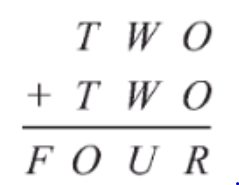

Definiendo el problema planteado por la imagen como un CSP tenemos:

$X = \{ O, W, T, R, U, F, x_{10}, x_{100}, x_{1000} \}$,

$D_i = \{ 1, 2, 3, 4, 5, 6, 7, 8, 9, 0 \} \quad \forall \quad X_i  \in X$,

$C = \{  \langle (O,W,T,R,U,F), Alldiff(O,W,T,R,U,F) \rangle, 
\quad \langle (O, R, x_{10}), x_{10} + R = 2 \cdot O \rangle,
\quad \langle (U, W, x_{10}, x_{100}), x_{10} + 2 \cdot W = U + x_{100} \rangle,
\quad \langle (T, O, x_{1000}, x_{100}), x_{100} + 2 \cdot T = O + x_{1000} \rangle\,
\quad \langle (F, x_{1000}), x_{1000} + F = 0 \rangle \}$.

Y a partir del problema planteado por la imagen se puede formular su representación como hipergrafo:

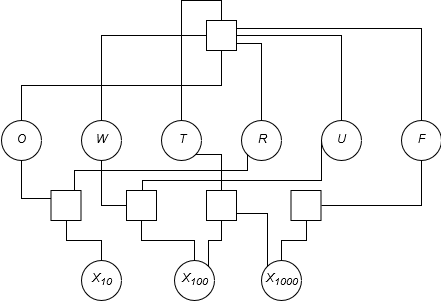

Recuerde que en los hipergrafos hay hipernodos representados por un rectángulo. En este caso, el hipernodo que se encuentra superior a las variables $F, T, U, W, R$ y $O$ es la restricción del tipo $Alldiff$, y los cuatro hipernodos restantes son las restricciones sobre las columnas de la suma.

Un ejemplo bastánte popular es el del juego de destreza mental *Sudoku*. En Sudoku nos piden, dado un espacio de estados inicial, asignar números a cada recuadro vacío de tal manera que: no exísta el mísmo número en la supercelda de 9x9 recuadros y que en el espacio renglón y colúmna en el que se encuentra la celda a asignar no exísta dicho número. Para esto podríamos establecer una restricción $Alldiff$ en el espacio renglón y colúmna al igual que en la supercelda de 9x9 recuadros.

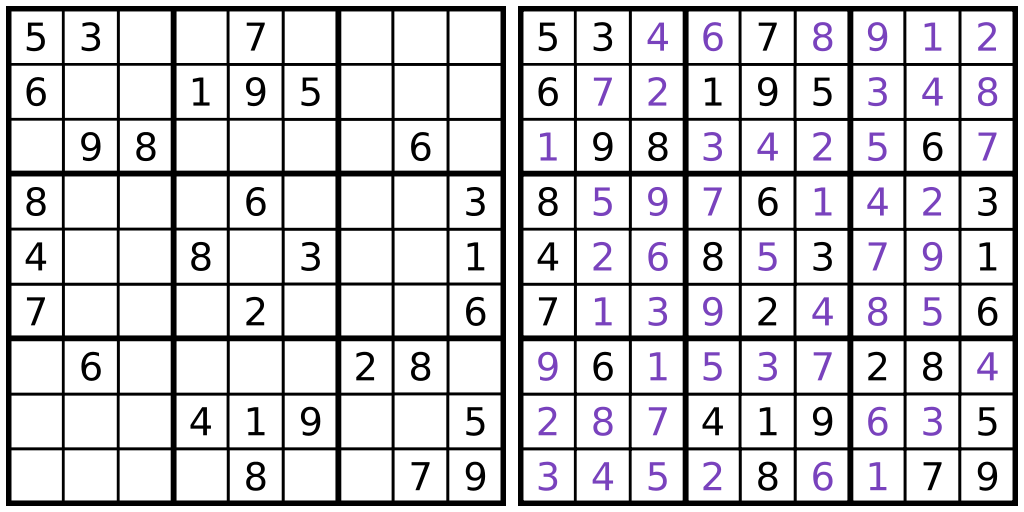

Un ejemplo más práctico es el de la programación de horarios de autobuses en una terminal; por ejemplo, se tienen que asignar los autobuses hacia un destino tal que el chofer tenga un descanso de 1 hora máximo y 30 minutos mínimo entre cada viaje, ningún autobús tiene que estar sin destino programado, dos autobuses no pueden ir al mísmo destino a menos que se haya alta demanda por el destino, los autobuses tengan suficiente combustible, etc.

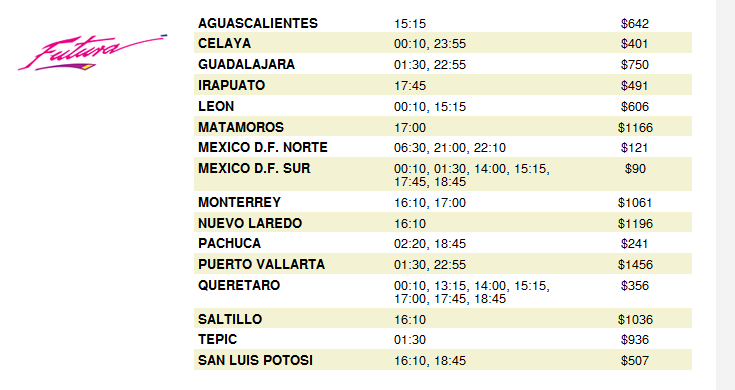

Para el problema de visión artificial exíste un algoritmo llamado **Algoritmo de Waltz**. Este algoritmo utiliza CSPs para interpretar dibujos de líneas de distintas geometrías <a href=http://citeseerx.ist.psu.edu/viewdoc/download;jsessionid=B79795871722F9037241A52458B9B255?doi=10.1.1.15.2644&rep=rep1&type=pdf>[2]</a>. Es capaz de decir si dos geometrías son equivalentes (similes a aquellos problemas representativos de los examenes de aptitudes). Define como variables a cada uno de los arcos que unen cada uno de los vértices y como dominios los símbolos que muestra la figura.

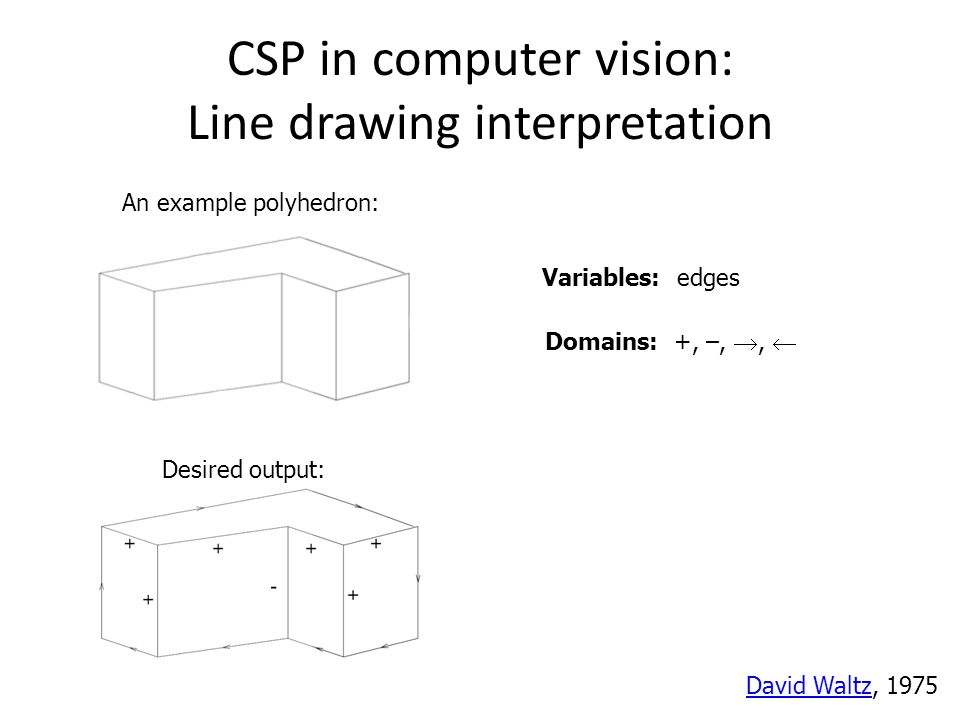

Finalmente, otro ejemplo curioso es el problema de las N-Reinas. Este problema consiste en colocar en un tablero de NxN espacios N reinas de tal manera que las N reinas no se ataquen entre sí.

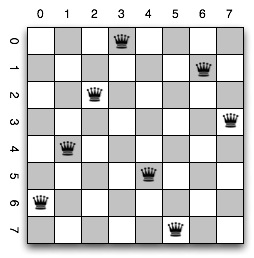

Este tipo de problemas son de especial valor para aquellos quienes se dedican a la economía, a la ingeniería industrial o cualquiera interesado en optimizar la asignación de recursos y valores. Es por esto que los CSPs son bastánte útiles en la vida real. Para problemas más complejos donde los dominios no son discretos exísten otros métodos de resolución en tiempo polinómico basados en la **programación lineal** y la **investigación de operadores**. <a>[3]</a>

### Caso de estudio: Coloreado de mapas

A lo largo de este tema estarémos discutiendo un problema particular: el *coloreado de grafos*, el cual puede ser extendido a **coloreado de mapas**. Para los matemáticos, el coloreado de mapas representó un problema difícil de resolver para un dominio de tan solo 4 colores y fue demostrado por Kenneth Appel y Wolfgang Haken hasta 1976 <a href=https://projecteuclid.org/download/pdf_1/euclid.bams/1183538218>[1]</a> con ayuda de software especializado en demostración de teoremas.
Para quien no conozca este problema, consiste en que dada cualquier separación de un plano en regiones contigüas, produciendo una figura llamada mapa, no se requieren más de 4 colores para colorear las regiones del mapa de tal manera que ningúna región adyacente tenga el mísmo color. Por adyacente se refiere a que dos regiones comparten un segmento de curva frontera, no simplemente una esquina donde tres o más regiones se intersectan.

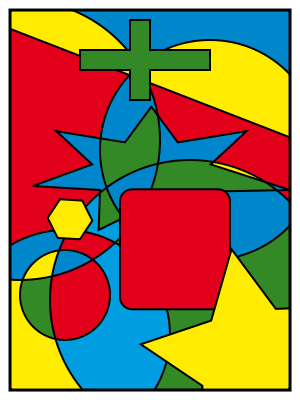

Nuestro caso de estudio será el coloreado de un mapa de Australia con cada uno de sus estados y territorios. Nos piden colorear cada región de rojo, verde o azul de tal manera que ningúna región colindante tengan el mísmo color. La pregunta ahora es ¿cómo podemos formular este problema como un CSP?, fácil: del enunciado abstraemos que requerimos asignar valores a variables de una forma específica, lo que nos indica que es aplicable la representación como un CPS. Esos valores son los colores *rojo*, *verde* y *azul*, de tal manera que 

$D_i = \lbrace rojo, verde, azul \rbrace$; 

ahora, ¿a qué necesitamos asignar estos colores?, del enunciado abstraemos que los territorios marcados en el mapa son los que deben ser coloreados, por lo que nuestras variables son 

$X = \{WA, NT, Q, NSW, V, SA, T\},$ 

donde por $WA$ nos referimos a *Western Australia*, $NT$ se refiere a *Northen Territory*, $Q$ a *Queensland*, $SA$ a *Southern Australia*, $V$ a *Victoria*, y $T$ a *Tasmania*. Finalmente, como restricciones a las asignaciones el problema define que las regiones vecinas deben tener distintos colores. Puesto que hay nueve lugares donde las regiones colindan, hay nueve restricciones:

$C= \{ WA \neq SA, NT \neq SA, SA \neq Q, SA \neq NSW, SA \neq V, NT \neq WA, NT \neq Q, Q \neq NSW, NSW \neq V \}$.

Para hacer la tipografía más sencilla de leer, $C_1 = \{ A \neq SA \}$ es quivalente con $C_1 = \langle (WA, SA), WA \neq SA \rangle$, que a su vez, de manera explícita es equivalente con

$C_1 = \langle (WA, SA), [ (rojo, verde), (rojo, azul), (verde, rojo), (verde, azul), (azul, rojo), (azul, verde)  ]\rangle$.

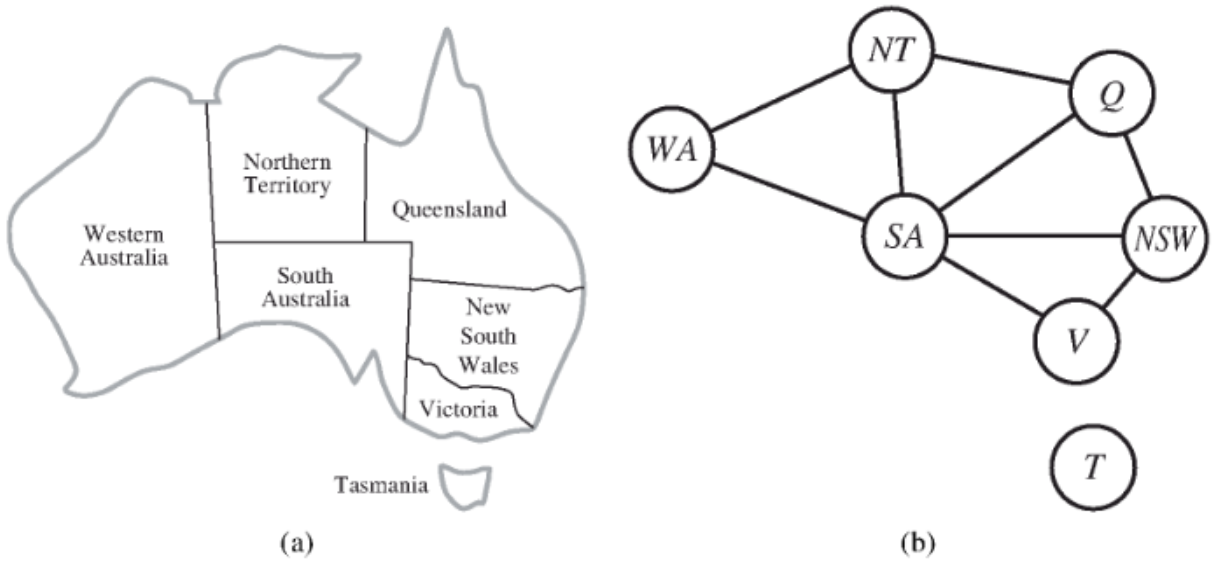

Es de mucha ayuda visualizar el CSP como un grafo con restricciones, como se muestra en la figura **(b)** del mapa de Australia. Los nodos del grafo corresponden a las variables del problema, y el arco que conecta a las variables entre sí representa una restricción.

Ahora hay que preguntar algo muy importante: **¿por qué representar el problema como un CSP?**. Es cierto, el problema puede ser representado como un problema de búsqueda, pero nuestro problema se presta demasiado a la formulación como CSP pues exísten restricciones obvias entre las variables y el problema provee toda la información para plantearlo como CSP. Además, recuerde el párrafo introductorio del tema:

> Los algoritmos de búsqueda utilizados en la resolución de CSPs aprovechan la estructura de los estados y utilizan heurísticas de propósito general; no son específicas del problema como las que hemos discutido hasta ahora; para habilitar la solución de problemas complejos. La idea principal es eliminar grandes porciones del espacio de búsqueda simultáneamente identificando la combinación de variable-valor que viola las restricciones.

Esto significa para nosotros que, si tenemos ya un sistema que soluciona CSPs, no es necesario formular un problema de búsqueda único para el problema en cuestión pues simplemente planteamos las variables, los dominios y las restricciones y solucionamos el problema con el sistema. Además, gracias a la generalidad de los métodos para solucionar CSPs la estructura del problema puede ser aprovechada para reducir mediante heurísticas la complejidad del problema y solucionarlo mucho más rápido que con los métodos de búsqueda que hemos visto hasta ahora. Por ejemplo, si hicieramos la asignación parcial de $\{SA = azul \}$, podemos concluir que ningúna de las 5 variables vecinas pueden tomar el color azul, lo que reduciría el dominio de las demás variables a $\{ rojo, verde \}$; a esto se le llama propagación de restricciones y lo verémos a detalle en los subtemas subsecuentes. Si no aprovecharamos la ventaja que nos brinda la propagación de restricciones en reducir el dominio, tendríamos que explorar $3^{5} = 243$ asignaciones para las cinco variables vecinas a $SA$; en cambio, con propagación de restricciones sólo tenemos que explorar $2^{5}= 32$ asignaciones. Si obtenemos cuánto se reduce, vemos que la reducción en casos a explorar es un $\frac {32}{243}\cdot 100\% \simeq 86.83\%$.

Para un problema de búsqueda estándar sólo podemos preguntar si el estado en el que nos encontramos es un estado meta para cada uno de los estados que visitamos; en cambio, con CSPs, si encontramos que una asignación parcial es incorrecta, descartamos inmediatamente refinaciones a la solución, pues la asignación parcial no es correcta y por lo tanto ahorramos tiempo de cómputo. Además, gracias a la estructura del problema, en el que las variables se encuentran relacionadas entre si, podemos ver qué variables parcialmente asignadas provocan una violación a la restricción, de tal manera que entonces podemos llevar nuestra atención hacia las variables que enverdad afectan la solución. Como resultado, muchos problemas que llevan mucho tiempo solucionar mediante búsqueda pueden ser resueltos rápidamente cuando son formulados como CSPs.

# Ejercicios para el asistente

**3.1** Obtenga una solución al CSP planteado para el mapa de Australia

**Haga doble click aquí para responder.**
*CTRL + Enter para mostrar el texto con formato*

**3.2** Plantee formalmente un CSP para el problema de las $N = 5$ reinas y diga:

   **a**. ¿Cuáles son los valores posibles para cada variable?

   **b**. ¿Cuáles son las variables restringidas y cómo se encuentran restringidas?

   **c**. ¿Cuáles son los dominios de las restricciones? ¿Puede reducir el dominio si la primera reina se encuentra en el   primer cuadro del tablero (posición 0, 0 de la imagen del tablero de ajedréz en la sección de ejemplos de CSPs)? Muestre cómo es que se reduce.

**Haga doble click aquí para responder.**
*CTRL + Enter para mostrar el texto con formato*

**3.3** Explique con sus propias palabras a qué se refiere el término *restriccón*.

**Haga doble click aquí para responder.**
*CTRL + Enter para mostrar el texto con formato*

**3.4** Defina el formalmente el CSP y el hipergrafo del siguiente problema de criptoaritmética:

$\begin{equation}
\frac{
    \begin{array}[b]{r}
         SEND \\
      +  MORE
    \end{array}
  }{
    MONEY
  }
\end{equation}$

**Haga doble click aquí para responder.**
*CTRL + Enter para mostrar el texto con formato*

**3.5** Sea el problema: 

$
 (X_1 \lor X_2 \lor X_6)\quad \land \quad (\neg X_1 \lor X_3 \lor X_4) \quad \land \quad (\neg X_4 \lor \neg X_5 \lor X_6) \quad \land \quad (X_2 \lor X_5 \lor \neg X_6) \quad \leftrightarrow \quad V
$

donde se definen los operadores $\lor$, $\land$, $\leftrightarrow$ y $\neg$ como:

$
\begin{array}{|c c|c|c|c|c|}
    p & q & p \land q & p \lor q & p \leftrightarrow q & \neg p \\ % Use & to separate the columns
    \hline  % Put a horizontal line between the table header and the rest.
    V & V & V & V & V & F \\
    V & F & F & V & F & F \\
    F & V & F & V & F & V \\
    F & F & F & F & V & V \\
\end{array}
$

Plantee formalmente el CSP, su hipergrafo y reduzca el CSP a un CSP binario por el método de transformación de grafo dual; además, obtenga el dominio de las nuevas variables definidas en el grafo dual resultado de la transformación.

**Haga doble click aquí para responder.**
*CTRL + Enter para mostrar el texto con formato*

**3.6** Muestre como una simple restricción ternaria tal como $\langle (A, B, C), A + B = C \rangle$ puede ser transformada en tres restricciones binarias al utilizar una variable auxiliar. Asumir dominios finitos. (*Pista:* Considerar una nueva variable que toma los valores que son pareja de otros valores, y considere restricciones tales como "*$X$ es el primer elemento de la pareja $Y$*"). Después, muestre como las restricciones con más de tres variables pueden ser tratadas de forma similar. Finalmente, muestre cuántas restricciones pueden ser eliminadas al alterar los dominios de las variables. Esto acompleta la demostración de que cualquier CSP puede ser transformado en un CSP con solo restricciones binarias.

**Haga doble click aquí para responder.**
*CTRL + Enter para mostrar el texto con formato*

# Fuentes consultadas y enlaces de interés

<a href=https://projecteuclid.org/download/pdf_1/euclid.bams/1183538218>[1]</a> APPEL, K. *et* HAKEN, W.; *Every Planar Map is Four Colorable*; Bulletin of The American Mathematical Society, 1976.

<a href=http://citeseerx.ist.psu.edu/viewdoc/download;jsessionid=B79795871722F9037241A52458B9B255?doi=10.1.1.15.2644&rep=rep1&type=pdf>[2]</a> WALTZ D.; *Understanding Line Drawings of Scenes with Shadows*; The Psychology of Computer Vision, 1975

<a>[3]</a> DANTZIG B. *et* THAPA. N; *Linear Programming I: Introduction*; Springer Series in Operations Research, 1997

<a href=https://en.wikipedia.org/wiki/Constraint_satisfaction_dual_problem>[4]</a>*Constraint Satisfaction Dual Problem*, Wikipedia.

<a href=http://www.aaai.org/Papers/FLAIRS/2001/FLAIRS01-069.pdf>[5]</a> PANG W. *et* GOODWIN D.; Binary Representations for General CSPs; AAAI, 2001.

<a>[6]</a> RUSSEL S. *et* NORVIG P.; <i>Artificial Intelligence: A modern approach</i>; Third Edition, Prentice Hall; New Jersey, EEUUA; p.p.1152, p.207